In [63]:
import pyart
from matplotlib import pyplot as plt
import numpy as np
from scipy import ndimage, signal, integrate
import time
import copy
%matplotlib inline

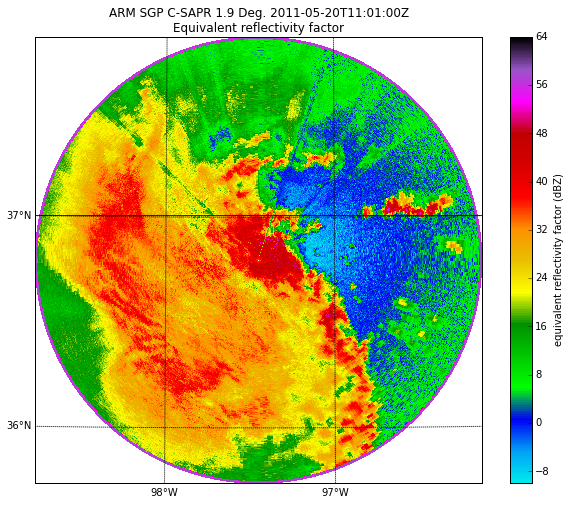

In [3]:
#radar = pyart.io.read('/data/sample_sapr_data/csapr_july9/sgpcsaprsurI7.00.20150709.111301.raw.cfrad.20150709_102911.531_CSAP_v4450_SUR.nc')
radar = pyart.io.read('/Users/scollis/projects/AMS-Short-Course-on-Open-Source-Radar-Software/data/110635.mdv')
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 2, resolution = 'i',
                    vmin = -10, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef)


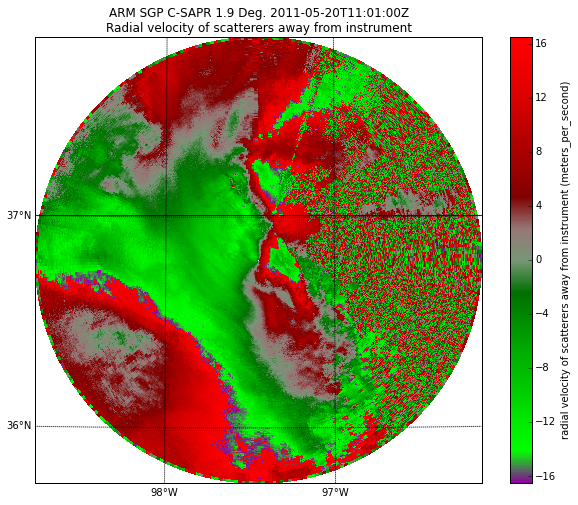

In [4]:
nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('velocity', sweep = 2, resolution = 'i',
                    vmin = -nyq, vmax = nyq, mask_outside = False,
                    cmap = pyart.graph.cm.NWSVel)

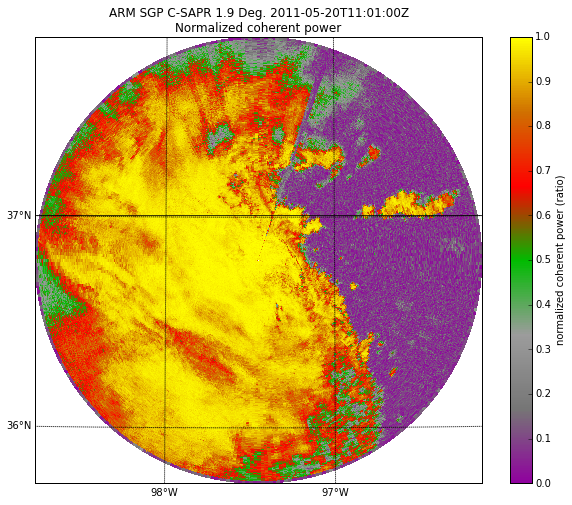

In [5]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('normalized_coherent_power', sweep = 2, resolution = 'i',
                    vmin = 0, vmax = 1, mask_outside = False,
                    cmap = pyart.graph.cm.NWS_SPW)


In [6]:
start_time = time.time()
data = ndimage.filters.generic_filter(radar.fields['velocity']['data'],
                                            pyart.util.interval_std, size = (4,4),
                                           extra_arguments = (-nyq, nyq))
total_time = time.time() - start_time
print(total_time)

248.98704195


In [7]:
filtered_data = ndimage.filters.median_filter(data, size = (4,4))
texture_field = pyart.config.get_metadata('velocity')
texture_field['data'] = filtered_data
radar.add_field('velocity_texture', texture_field, replace_existing = True)

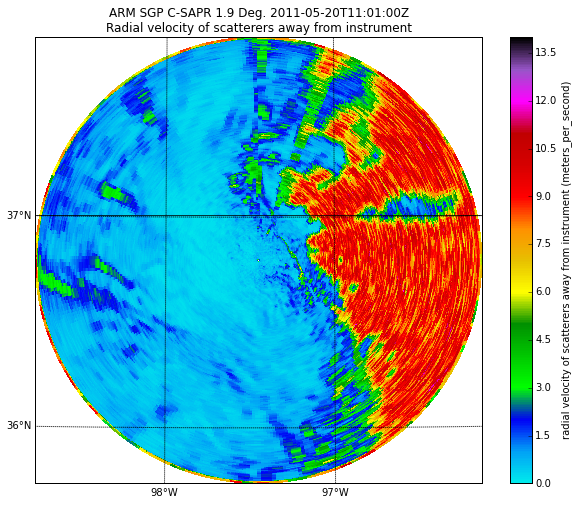

In [8]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('velocity_texture', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = 0, vmax = 14)

In [40]:
n, bins = np.histogram(filtered_data.flatten(), bins = 150)
peaks = signal.find_peaks_cwt(n, np.array([10]))
centers = bins[0:-1] + (bins[1] - bins[0])
search_data = n[peaks[0]:peaks[1]]
search_centers = centers[peaks[0]:peaks[1]]
locs = search_data.argsort()
location_of_minima = locs[0]

1.11832285943


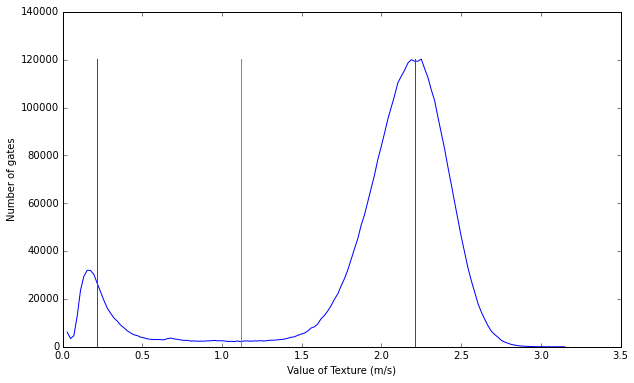

In [41]:
fig = plt.figure(figsize = [10,6])
plt.plot(centers, n)
zmax = n.max()
plt.plot([centers[peaks[0]], centers[peaks[0]]], [0, zmax])
plt.plot([centers[peaks[1]], centers[peaks[1]]], [0, zmax])
plt.plot([search_centers[location_of_minima], search_centers[location_of_minima]], [0, zmax])
noise_threshold = search_centers[locs[0]]
print(noise_threshold)
plt.xlabel('Value of Texture (m/s)')
plt.ylabel('Number of gates')

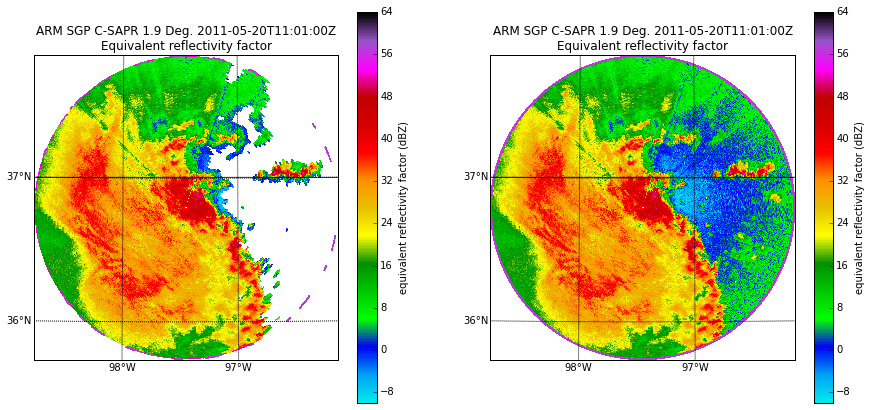

In [12]:
likely_noise = filtered_data > noise_threshold
likely_signal = np.logical_not(likely_noise)

z_masked = np.ma.masked_where(likely_noise, radar.fields['reflectivity']['data'])
radar.add_field_like('reflectivity', 
                     'reflectivity_masked', 
                     z_masked, replace_existing = True)
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [15,7])
plt.subplot(1,2,1)
display.plot_ppi_map('reflectivity_masked', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64)
plt.subplot(1,2,2)
display.plot_ppi_map('reflectivity', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64)

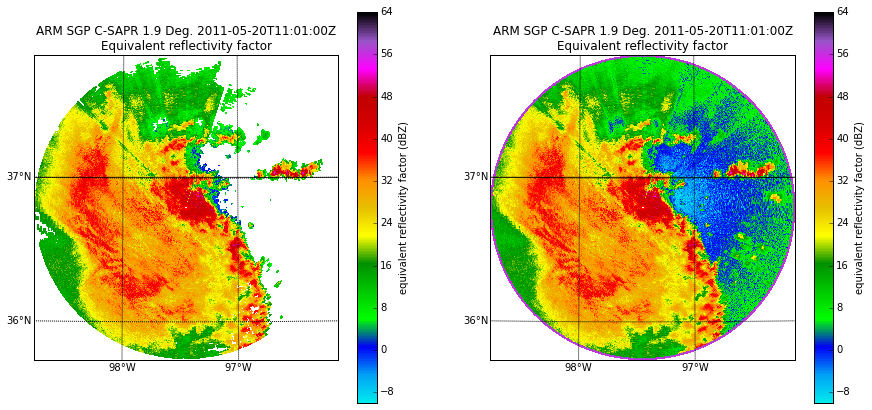

In [13]:
likely_noise = radar.fields['normalized_coherent_power']['data'] < .5
likely_signal = np.logical_not(likely_noise)

z_masked = np.ma.masked_where(likely_noise, radar.fields['reflectivity']['data'])
radar.add_field_like('reflectivity', 
                     'reflectivity_masked2', 
                     z_masked, replace_existing = True)
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [15,7])
plt.subplot(1,2,1)
display.plot_ppi_map('reflectivity_masked2', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64)
plt.subplot(1,2,2)
display.plot_ppi_map('reflectivity', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64)

In [14]:
gatefilter = pyart.correct.GateFilter(radar)
gatefilter.exclude_masked('reflectivity_masked')
corr_vel = pyart.correct.dealias_region_based(
    radar, vel_field='velocity', keep_original=False, 
    gatefilter = gatefilter, nyquist_vel=nyq, centered = True)
radar.add_field('corrected_velocity', corr_vel, replace_existing = True)

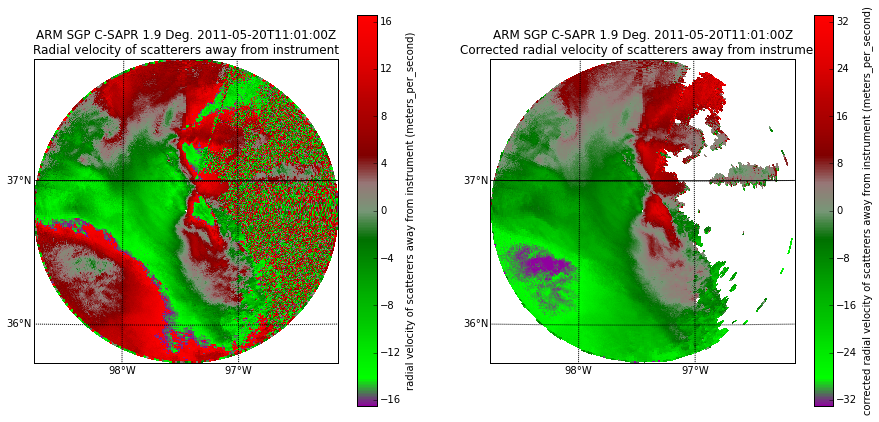

In [15]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [15,7])
plt.subplot(1,2,1)
display.plot_ppi_map('velocity', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSVel,
                    vmin = -nyq, vmax = nyq)
plt.subplot(1,2,2)
display.plot_ppi_map('corrected_velocity', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSVel,
                    vmin = -2*nyq, vmax = 2*nyq)

In [16]:
radar2 = pyart.io.read('/Users/scollis/projects/DoE/notebooks-2/ASR_PI_2014/pvcwsacrhsrhiM1.b1.20121105.201200_modified.nc')

(0, 3)

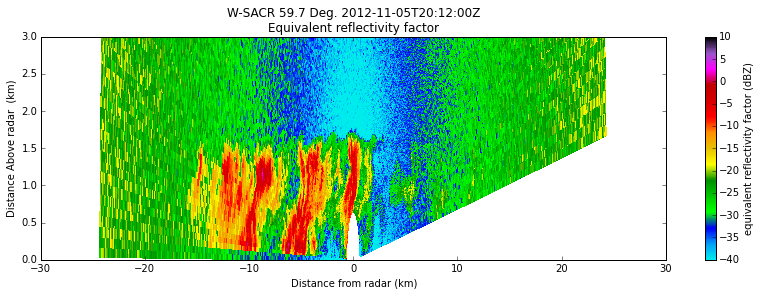

In [17]:
display = pyart.graph.RadarDisplay(radar2)
fig = plt.figure(figsize = [14,4])
display.plot_rhi('reflectivity', sweep = 2, 
                    vmin = -40, vmax = 10, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef)
plt.ylim([0,3])

(0, 3)

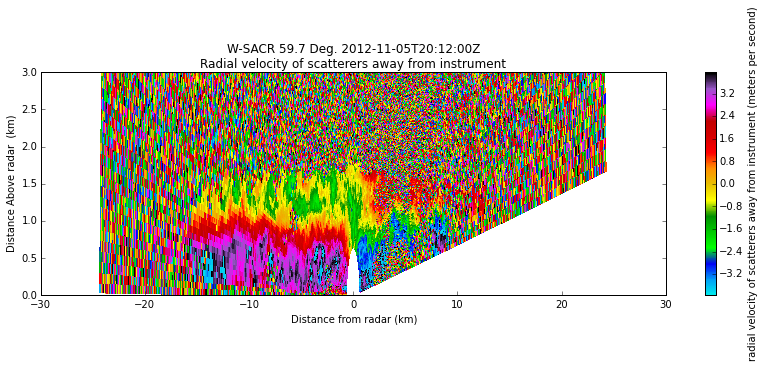

In [18]:
nyq = radar2.instrument_parameters['nyquist_velocity']['data'][0]

display = pyart.graph.RadarDisplay(radar2)
fig = plt.figure(figsize = [14,4])
display.plot_rhi('mean_doppler_velocity', sweep = 2, 
                    vmin = -nyq, vmax = nyq, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef)
plt.ylim([0,3])

In [20]:
nyq = radar2.instrument_parameters['nyquist_velocity']['data'][0]

data = ndimage.filters.generic_filter(radar2.fields['mean_doppler_velocity']['data'],
                                            pyart.util.interval_std, size = (4,4),
                                           extra_arguments = (-nyq, nyq))


In [21]:
filtered_data = ndimage.filters.median_filter(data, size = (4,4))
texture_field = pyart.config.get_metadata('velocity')
texture_field['data'] = filtered_data
radar2.add_field('velocity_texture', texture_field, replace_existing = True)

(0, 5)

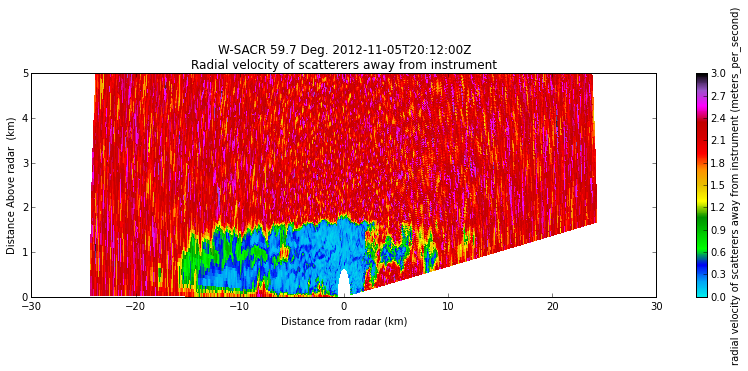

In [22]:
display = pyart.graph.RadarDisplay(radar2)
fig = plt.figure(figsize = [14,4])
display.plot_rhi('velocity_texture', sweep = 2,
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = 0, vmax = 3)
plt.ylim([0,5])


1.11832285943


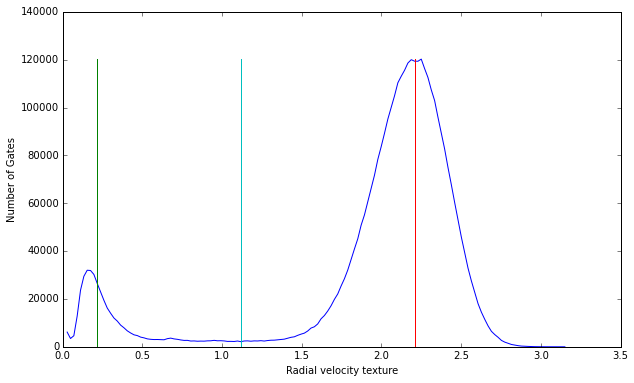

In [23]:
fig = plt.figure(figsize = [10,6])
n, bins = np.histogram(filtered_data.flatten(), bins = 150)
peaks = signal.find_peaks_cwt(n, np.array([10]))
centers = bins[0:-1] + (bins[1] - bins[0])
search_data = n[peaks[0]:peaks[1]]
search_centers = centers[peaks[0]:peaks[1]]
locs = search_data.argsort()
location_of_minima = locs[0]
plt.xlabel('Radial velocity texture')
plt.ylabel('Number of Gates')
plt.plot(centers, n)
zmax = n.max()
plt.plot([centers[peaks[0]], centers[peaks[0]]], [0, zmax])
plt.plot([centers[peaks[1]], centers[peaks[1]]], [0, zmax])
plt.plot([search_centers[location_of_minima], search_centers[location_of_minima]], [0, zmax])
noise_threshold = search_centers[locs[0]]
print(noise_threshold)

In [24]:
likely_noise = filtered_data > noise_threshold
likely_signal = np.logical_not(likely_noise)
z_m = np.ma.masked_where(likely_noise, radar2.fields['reflectivity']['data'])
z_m_field = pyart.config.get_metadata('reflectivity')
z_m_field['data'] = z_m
radar2.add_field('reflectivity_masked', z_m_field, replace_existing = True)


(-20, 20)

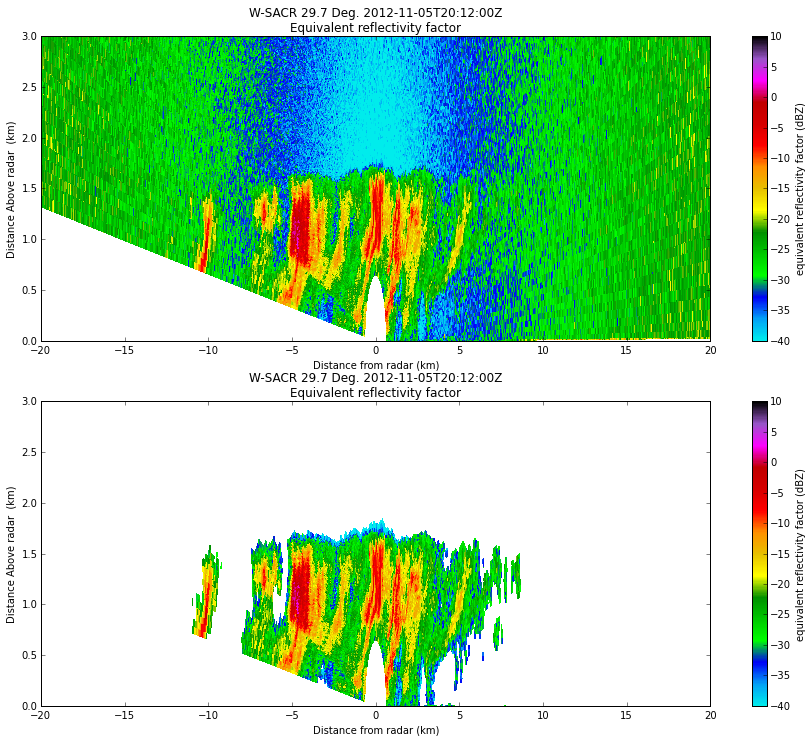

In [25]:
display = pyart.graph.RadarDisplay(radar2)
fig = plt.figure(figsize = [15,12])
plt.subplot(2,1,1)
display.plot_rhi('reflectivity', sweep = 1,
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -40, vmax = 10)
plt.ylim([0,3])
plt.xlim([-20,20])
plt.subplot(2,1,2)
display.plot_rhi('reflectivity_masked', sweep = 1,
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -40, vmax = 10)
plt.ylim([0,3])
plt.xlim([-20,20])

In [26]:
phidp, kdp = pyart.correct.phase_proc_lp(radar, 0.0, debug=True)

Unfolding
Exec time:  15.1161010265
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/pyart/correct/phase_proc.py:188: RuntimeWarning: invalid value encountered in sqrt
  noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:183: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number inste

 0
Doing  1
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:183: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer n

 2
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 3
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 4
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 5
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 6
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 7
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 8
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 9
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 10
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 11
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 12
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 13
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 14
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 15
Doing 

/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

 16


/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:300: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = zeros((n, n), v.dtype)
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res[:n-k].flat[i::n+1] = v
/Users/scollis/anaconda/lib/python2.7/site-packages/numpy/lib/twodim_base.py:305: DeprecationWarning: using a non-integer nu

In [27]:
radar.add_field('corrected_differential_phase', phidp)
radar.add_field('corrected_specific_diff_phase', kdp)


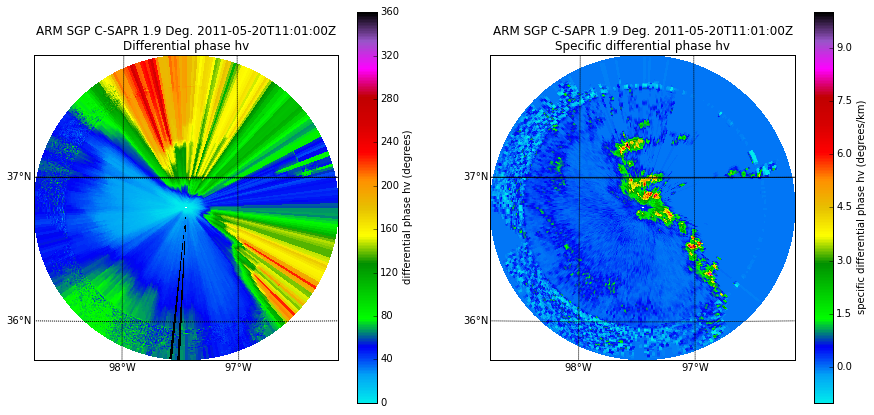

In [28]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [15,7])
plt.subplot(1,2,1)
display.plot_ppi_map('corrected_differential_phase', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = 0, vmax = 360)
plt.subplot(1,2,2)
display.plot_ppi_map('corrected_specific_diff_phase', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -1, vmax = 10)

In [65]:
fakephidp = np.zeros_like(radar.fields['corrected_specific_diff_phase']['data'])

moo = copy.deepcopy(radar.fields['corrected_specific_diff_phase']['data'])
moo[radar.fields['corrected_specific_diff_phase']['data'] > 15.0] = 15.0
new_phidp = integrate.cumtrapz(moo,
                               radar.range['data'], axis=1)
fakephidp[:,0:-1]= new_phidp
radar.add_field_like('corrected_differential_phase', 'corrected_differential_phase_2', 
                     fakephidp/500.,replace_existing = True)

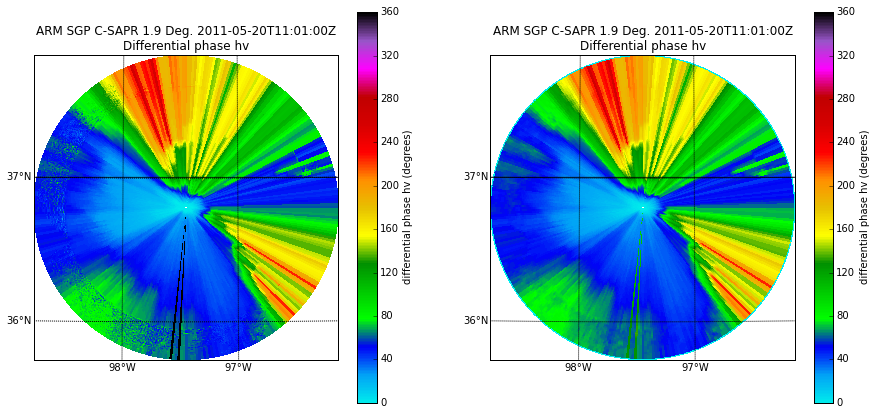

In [67]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [15,7])
plt.subplot(1,2,1)
display.plot_ppi_map('corrected_differential_phase', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = 0, vmax = 360)
plt.subplot(1,2,2)
display.plot_ppi_map('corrected_differential_phase_2', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = 0, vmax = 360)


In [70]:
spec_at, cor_z = pyart.correct.calculate_attenuation(
    radar, 0, refl_field='reflectivity_masked',
    ncp_field='normalized_coherent_power', rhv_field='cross_correlation_ratio',
    phidp_field='corrected_differential_phase_2')
radar.add_field('specific_attenuation', spec_at, replace_existing = True)
radar.add_field('corrected_reflectivity_horizontal', cor_z, replace_existing = True)


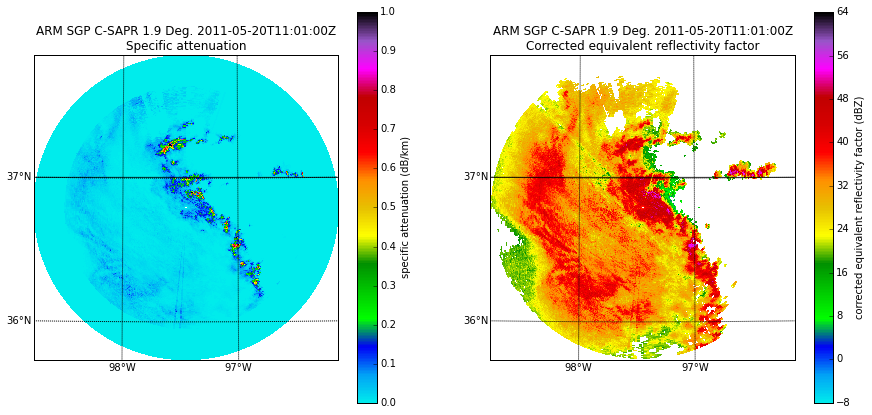

In [71]:
fig = plt.figure(figsize = [15,7])
display = pyart.graph.RadarMapDisplay(radar)
plt.subplot(1,2,1)
display.plot_ppi_map('specific_attenuation', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = 0, vmax = 1)
plt.subplot(1,2,2)
display.plot_ppi_map('corrected_reflectivity_horizontal', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -8, vmax = 64)

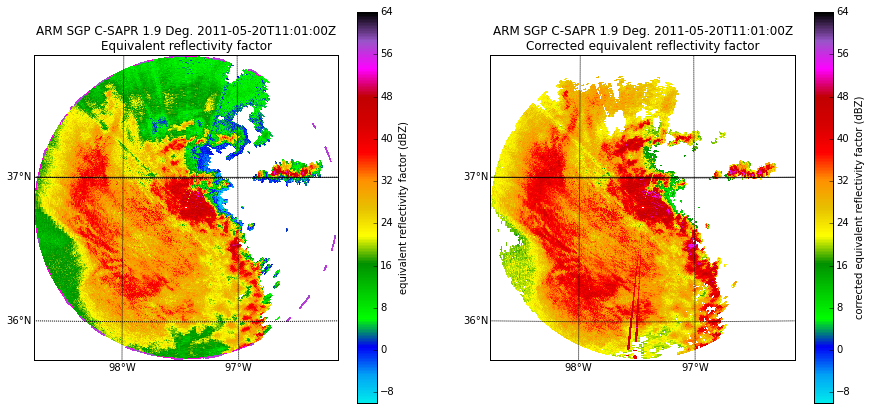

In [39]:
fig = plt.figure(figsize = [15,7])

display = pyart.graph.RadarMapDisplay(radar)
plt.subplot(1,2,1)
display.plot_ppi_map('reflectivity_masked', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64)
plt.subplot(1,2,2)
display.plot_ppi_map('corrected_reflectivity_horizontal', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64)

In [75]:
fakeintA = np.zeros_like(radar.fields['specific_attenuation']['data'])

moo = copy.deepcopy(radar.fields['specific_attenuation']['data'])
new_A = integrate.cumtrapz(moo,
                               radar.range['data'], axis=1)
fakeintA[:,0:-1]= new_A
radar.add_field_like('corrected_reflectivity_horizontal', 'corrected_reflectivity_horizontal_2', 
                     fakeintA/500. + radar.fields['reflectivity_masked']['data'],replace_existing = True)

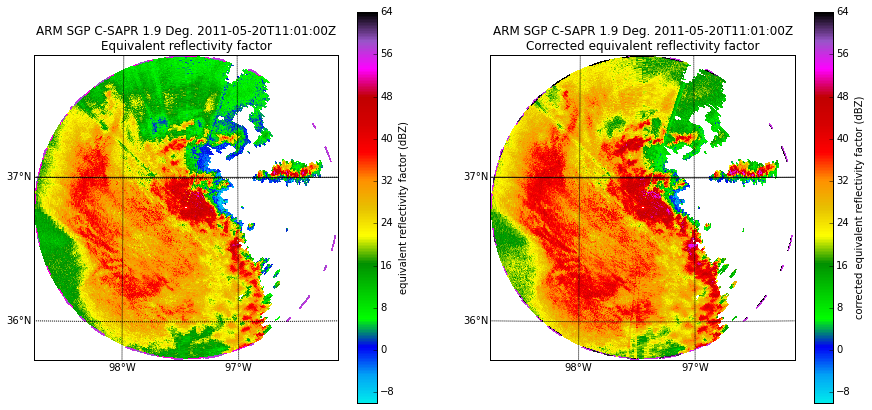

In [76]:
fig = plt.figure(figsize = [15,7])

display = pyart.graph.RadarMapDisplay(radar)
plt.subplot(1,2,1)
display.plot_ppi_map('reflectivity_masked', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64)
plt.subplot(1,2,2)
display.plot_ppi_map('corrected_reflectivity_horizontal_2', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64)